# Testing Dat bias Approches

## Data Bias Methods and Mitigation Strategies
### Class Imbalance Detection and Mitigation

#### Method: Class Imbalance Detection

Description: Detecting class imbalance involves analyzing the distribution of different classes within a dataset. Imbalance occurs when some classes are significantly underrepresented compared to others.
* Detection: Use descriptive statistics and visualizations like bar plots to understand class distribution.
* Mitigation Strategies:
* Resampling Techniques: Apply oversampling (e.g., SMOTE) to increase minority class examples or undersampling to reduce majority class examples.
* Algorithmic Adjustments: Use algorithms that are robust to class imbalance, such as cost-sensitive learning.
* Reference: Imbalanced-learn library

## Titanic Dataset Analysis: Handling Class Imbalance

In this example, we focus on addressing class imbalance in the Titanic dataset and evaluating how it affects model performance. Below is an outline of our objectives and the basis of data bias in this context:

### Goals

1. **Handle Class Imbalance**:
   - The Titanic dataset often exhibits class imbalance, where one class (e.g., `Survived=1`) may be underrepresented compared to the other class (e.g., `Survived=0`). This imbalance can adversely affect model performance, leading to biased predictions.

2. **Apply SMOTE (Synthetic Minority Over-sampling Technique)**:
   - SMOTE is employed to balance the dataset by generating synthetic samples for the minority class. This technique helps the model learn more effectively and generalize better by providing additional examples of the underrepresented class.

3. **Compare Class Distributions**:
   - By comparing class distributions before and after applying SMOTE, we can visualize the impact of balancing techniques and better understand the extent of imbalance.

### Basis of Data Bias

1. **Class Imbalance**:
   - **Definition**: Class imbalance occurs when one class has significantly fewer samples than another. For example, in the Titanic dataset, if the number of survivors (`Survived=1`) is much smaller than the number of non-survivors (`Survived=0`), the dataset is considered biased.
   - **Impact**: This imbalance can lead to models that are biased towards the majority class, resulting in poor performance on the minority class. The model might predict the majority class more often due to its higher frequency in the training data.

2. **Why It’s a Problem**:
   - **Evaluation Metrics**: Traditional metrics like accuracy can be misleading with imbalanced classes. A model predicting only the majority class may still achieve high accuracy but fail to perform well in real-world scenarios where balanced performance is crucial.
   - **Model Training**: Imbalanced data can cause models to be overly sensitive to the majority class and less capable of detecting patterns in the minority class.

### Steps to Address Data Bias

1. **Data Exploration and Preprocessing**:
   - **Analyze Class Distribution**: Examine the distribution of classes in the dataset to identify any imbalance.
   - **Handle Missing Values**: Clean the dataset by addressing missing values to prevent additional bias.

2. **Apply Resampling Techniques**:
   - **Oversampling**: Techniques such as SMOTE generate synthetic samples for the minority class, balancing the dataset and improving the model’s ability to learn from both classes.

3. **Evaluate Performance**:
   - **Compare Metrics**: Assess the model's performance using metrics that account for class imbalance, including precision, recall, F1-score, and the area under the ROC curve (AUC-ROC).

### Example Code Explanation

1. **Data Loading and Preprocessing**:
   - Load and preprocess the Titanic dataset to handle missing values and convert categorical features into numerical ones.
   - Separate features (`X`) and target (`y`), then split them into training and testing sets.

2. **Apply SMOTE**:
   - Apply SMOTE to the training data to generate synthetic samples for the minority class, thereby balancing the dataset.

3. **Convert to PyTorch Tensors**:
   - Convert the resampled data into PyTorch tensors for model training.

4. **Plot Class Distributions**:
   - Visualize the class distributions before and after applying SMOTE using pie charts to illustrate the effects of balancing.

By implementing these steps, our goal is to build a model that performs well across both classes, avoiding bias towards any particular class due to imbalance. This approach helps in creating a more robust and fair model, essential for real-world applications where balanced performance is key.


Original class distribution:
0    298
1    201
Name: count, dtype: int64

Resampled class distribution:
0    298
1    298
Name: count, dtype: int64


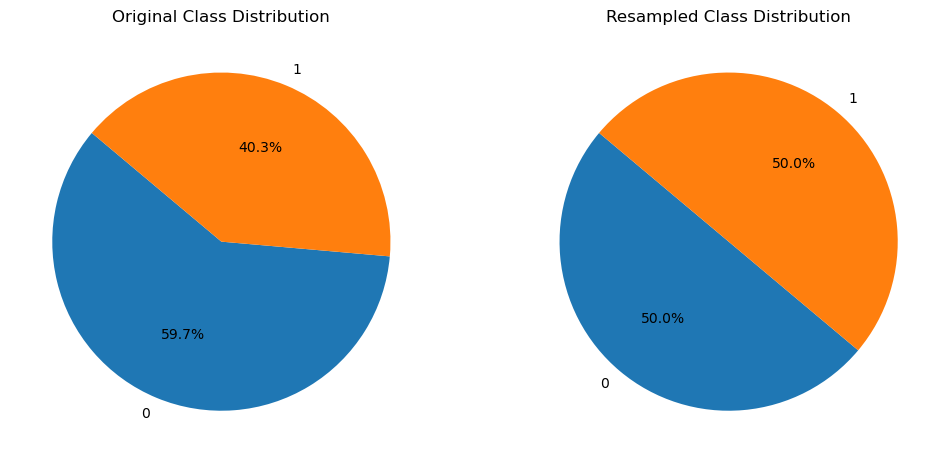

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load Titanic dataset
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
data = pd.read_csv(url)

# Preprocess the data
data = data[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']]
data = data.dropna()  # Drop rows with missing values

# Convert categorical data to numeric
label_encoders = {}
for column in ['Sex']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Define features and target
X = data.drop('Survived', axis=1).values  # Convert DataFrame to NumPy array
y = data['Survived'].values  # Convert Series to NumPy array

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Convert to PyTorch tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
dataset_resampled = TensorDataset(X_resampled, y_resampled)
dataloader_resampled = DataLoader(dataset_resampled, batch_size=32, shuffle=True)

# Print class distribution before and after SMOTE
print("Original class distribution:")
print(pd.Series(y_train).value_counts())
print("\nResampled class distribution:")
print(pd.Series(y_resampled.numpy()).value_counts())

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot original distribution
ax[0].pie(pd.Series(y_train).value_counts(), labels=pd.Series(y_train).value_counts().index, autopct='%1.1f%%', startangle=140)
ax[0].set_title('Original Class Distribution')

# Plot resampled distribution
ax[1].pie(pd.Series(y_resampled.numpy()).value_counts(), labels=pd.Series(y_resampled.numpy()).value_counts().index, autopct='%1.1f%%', startangle=140)
ax[1].set_title('Resampled Class Distribution')

plt.show()


In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Preprocessing
data.fillna(method='ffill', inplace=True)
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
data['Embarked'] = LabelEncoder().fit_transform(data['Embarked'].astype(str))

# Features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = data[features]
y = data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data and retain indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42
)

# Custom Dataset class
class TitanicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoader
train_dataset = TitanicDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define a simple neural network model
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1], 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss, and optimizer
model = SimpleNN()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}')

# Evaluate and calculate disparate impact
model.eval()
with torch.no_grad():
    y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

# Convert predictions and true labels to DataFrame
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
results.index = test_indices  # Add index back to results

# Add gender information back to the results DataFrame
results = results.join(data.loc[test_indices, ['Sex']])

# Disparate Impact Analysis
def calculate_disparate_impact(df, group_col, target_col):
    group_stats = df.groupby(group_col).agg(
        total=(target_col, 'size'),
        positive=(target_col, 'sum')
    )
    group_stats['rate'] = group_stats['positive'] / group_stats['total']
    return group_stats

# Calculate disparate impact for gender
disparate_impact_gender = calculate_disparate_impact(results, 'Sex', 'Predicted')

# Print results
print("\nDisparate Impact by Gender:")
print(disparate_impact_gender)

# Mitigation Strategy: Reweighting
# Compute class weights for reweighting
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Modify the loss function to use class weights
weighted_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# Retrain the model with reweighted loss
model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = weighted_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}')

# Reevaluate and calculate disparate impact after reweighting
model.eval()
with torch.no_grad():
    y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
results.index = test_indices  # Add index back to results
results = results.join(data.loc[test_indices, ['Sex']])
disparate_impact_gender = calculate_disparate_impact(results, 'Sex', 'Predicted')

print("\nDisparate Impact by Gender After Reweighting:")
print(disparate_impact_gender)


Epoch 1/10, Loss: 0.563833475112915
Epoch 2/10, Loss: 0.5249218344688416
Epoch 3/10, Loss: 0.30053988099098206
Epoch 4/10, Loss: 0.206588476896286
Epoch 5/10, Loss: 0.477924644947052
Epoch 6/10, Loss: 0.832263171672821
Epoch 7/10, Loss: 0.7024707794189453
Epoch 8/10, Loss: 0.6070451140403748
Epoch 9/10, Loss: 0.13467617332935333
Epoch 10/10, Loss: 0.23749326169490814

Disparate Impact by Gender:
     total  positive      rate
Sex                           
0       69        63  0.913043
1      110         4  0.036364
Epoch 1/10, Loss: 0.8326300382614136
Epoch 2/10, Loss: 0.7790358066558838
Epoch 3/10, Loss: 0.7613989114761353
Epoch 4/10, Loss: 0.8067701458930969
Epoch 5/10, Loss: 0.7532530426979065
Epoch 6/10, Loss: 0.6705517172813416
Epoch 7/10, Loss: 0.7746355533599854
Epoch 8/10, Loss: 0.6554311513900757
Epoch 9/10, Loss: 0.6344607472419739
Epoch 10/10, Loss: 0.7969929575920105

Disparate Impact by Gender After Reweighting:
     total  positive      rate
Sex                         

Epoch 1/10, Loss: 0.6283786296844482
Epoch 2/10, Loss: 0.5156815052032471
Epoch 3/10, Loss: 0.5050393342971802
Epoch 4/10, Loss: 0.40626078844070435
Epoch 5/10, Loss: 0.40236911177635193
Epoch 6/10, Loss: 0.4240565299987793
Epoch 7/10, Loss: 0.23425136506557465
Epoch 8/10, Loss: 0.3587748110294342
Epoch 9/10, Loss: 0.397993803024292
Epoch 10/10, Loss: 0.2578964829444885

Disparate Impact by Gender Before Reweighting:
     total  positive      rate
Sex                           
0       69        62  0.898551
1      110         3  0.027273

Disparate Impact Ratio Before Reweighting: 0.03
Epoch 1/10, Loss: 0.861395537853241
Epoch 2/10, Loss: 0.7557549476623535
Epoch 3/10, Loss: 0.792518138885498
Epoch 4/10, Loss: 0.7811217904090881
Epoch 5/10, Loss: 0.768951952457428
Epoch 6/10, Loss: 0.7490954995155334
Epoch 7/10, Loss: 0.6494475603103638
Epoch 8/10, Loss: 0.6602770686149597
Epoch 9/10, Loss: 0.6136594414710999
Epoch 10/10, Loss: 0.6443479061126709

Disparate Impact by Gender After Rewe

/tmp/ipykernel_216843/2002799284.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
/tmp/ipykernel_216843/2002799284.py:174: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')


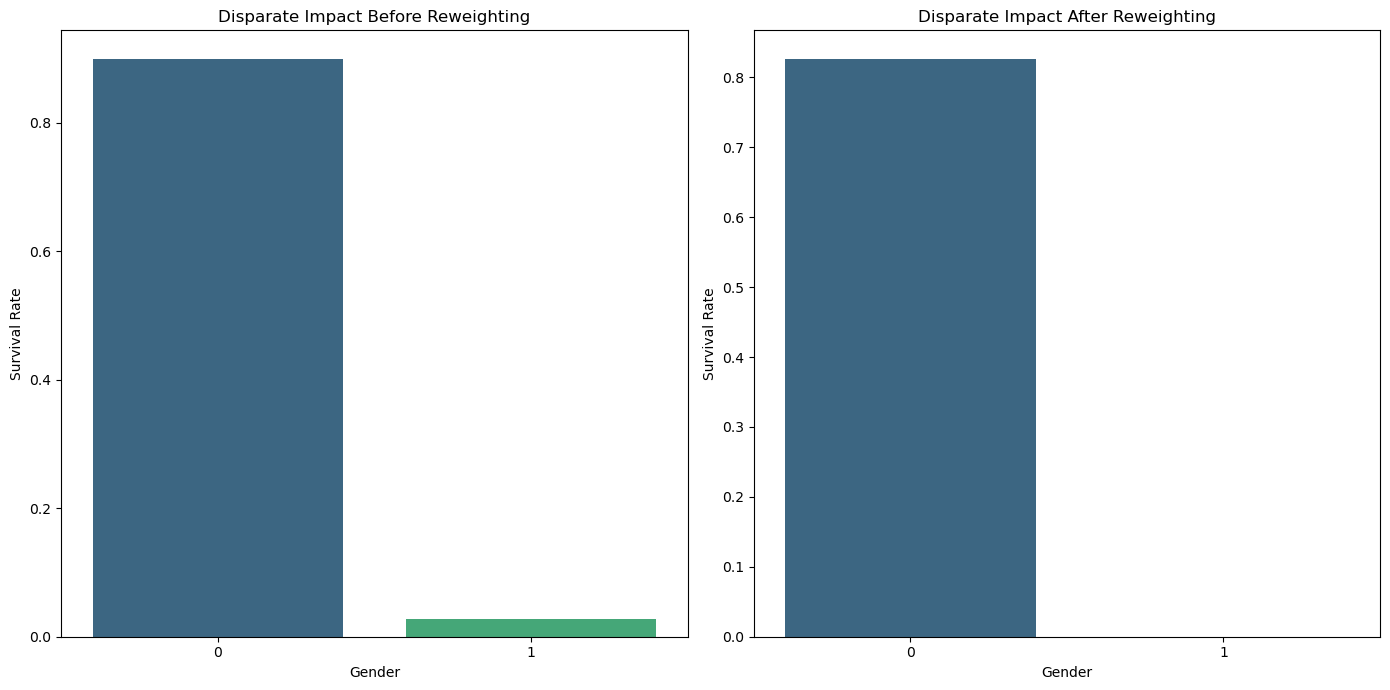


Disparate Impact Table Before Reweighting:
     total  positive      rate
Sex                           
0       69        62  0.898551
1      110         3  0.027273

Disparate Impact Table After Reweighting:
     total  positive      rate
Sex                           
0       69        57  0.826087
1      110         0  0.000000


In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Preprocessing
data.fillna(method='ffill', inplace=True)
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
data['Embarked'] = LabelEncoder().fit_transform(data['Embarked'].astype(str))

# Features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = data[features]
y = data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data and retain indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42
)

# Custom Dataset class
class TitanicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoader
train_dataset = TitanicDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define a simple neural network model
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1], 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss, and optimizer
model = SimpleNN()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}')

# Evaluate and calculate disparate impact before reweighting
model.eval()
with torch.no_grad():
    y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

# Convert predictions and true labels to DataFrame
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
results.index = test_indices  # Add index back to results

# Add gender information back to the results DataFrame
results = results.join(data.loc[test_indices, ['Sex']])

# Disparate Impact Analysis Function
def calculate_disparate_impact(df, group_col, target_col):
    group_stats = df.groupby(group_col).agg(
        total=(target_col, 'size'),
        positive=(target_col, 'sum')
    )
    group_stats['rate'] = group_stats['positive'] / group_stats['total']
    return group_stats

# Calculate disparate impact for gender
disparate_impact_gender = calculate_disparate_impact(results, 'Sex', 'Predicted')

# Calculate Disparate Impact Ratio
disparate_impact_ratio = disparate_impact_gender['rate'].min() / disparate_impact_gender['rate'].max()

# Print results before mitigation
print("\nDisparate Impact by Gender Before Reweighting:")
print(disparate_impact_gender)
print(f"\nDisparate Impact Ratio Before Reweighting: {disparate_impact_ratio:.2f}")

# Mitigation Strategy: Reweighting
# Compute class weights for reweighting
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Modify the loss function to use class weights
weighted_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# Retrain the model with reweighted loss
model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = weighted_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}')

# Reevaluate and calculate disparate impact after reweighting
model.eval()
with torch.no_grad():
    y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
results.index = test_indices  # Add index back to results
results = results.join(data.loc[test_indices, ['Sex']])
disparate_impact_gender_after = calculate_disparate_impact(results, 'Sex', 'Predicted')

# Calculate Disparate Impact Ratio After Reweighting
disparate_impact_ratio_after = disparate_impact_gender_after['rate'].min() / disparate_impact_gender_after['rate'].max()

# Print results after mitigation
print("\nDisparate Impact by Gender After Reweighting:")
print(disparate_impact_gender_after)
print(f"\nDisparate Impact Ratio After Reweighting: {disparate_impact_ratio_after:.2f}")

# Visualization Function
def plot_disparate_impact(df_before, df_after):
    df_before = df_before.reset_index()
    df_after = df_after.reset_index()

    plt.figure(figsize=(14, 7))

    # Plot before reweighting
    plt.subplot(1, 2, 1)
    sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
    plt.title('Disparate Impact Before Reweighting')
    plt.xlabel('Gender')
    plt.ylabel('Survival Rate')

    # Plot after reweighting
    plt.subplot(1, 2, 2)
    sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')
    plt.title('Disparate Impact After Reweighting')
    plt.xlabel('Gender')
    plt.ylabel('Survival Rate')

    plt.tight_layout()
    plt.show()

# Plot results
plot_disparate_impact(disparate_impact_gender, disparate_impact_gender_after)

# Table Visualization
def display_tables(df_before, df_after):
    print("\nDisparate Impact Table Before Reweighting:")
    print(df_before)

    print("\nDisparate Impact Table After Reweighting:")
    print(df_after)

# Display tables
display_tables(disparate_impact_gender, disparate_impact_gender_after)


Epoch 1/10, Loss: 0.57606440782547
Epoch 2/10, Loss: 0.5490393042564392
Epoch 3/10, Loss: 0.38798317313194275
Epoch 4/10, Loss: 0.47487202286720276
Epoch 5/10, Loss: 0.4867708683013916
Epoch 6/10, Loss: 0.24888421595096588
Epoch 7/10, Loss: 0.35349830985069275
Epoch 8/10, Loss: 0.4481804370880127
Epoch 9/10, Loss: 0.3602900803089142
Epoch 10/10, Loss: 0.34730109572410583

Disparate Impact by Gender Before Reweighting:
     total  positive      rate
Sex                           
0       69        64  0.927536
1      110        11  0.100000

Disparate Impact Ratio Before Reweighting: 0.11
Epoch 1/10, Loss: 0.8115928173065186
Epoch 2/10, Loss: 0.6968836784362793
Epoch 3/10, Loss: 0.6782476902008057
Epoch 4/10, Loss: 0.6203829646110535
Epoch 5/10, Loss: 0.6209930181503296
Epoch 6/10, Loss: 0.6835375428199768
Epoch 7/10, Loss: 0.6467108726501465
Epoch 8/10, Loss: 0.6851997971534729
Epoch 9/10, Loss: 0.621936023235321
Epoch 10/10, Loss: 0.7622472643852234
Epoch 11/10, Loss: 0.61973136663436

/tmp/ipykernel_216843/1166672267.py:191: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
/tmp/ipykernel_216843/1166672267.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')


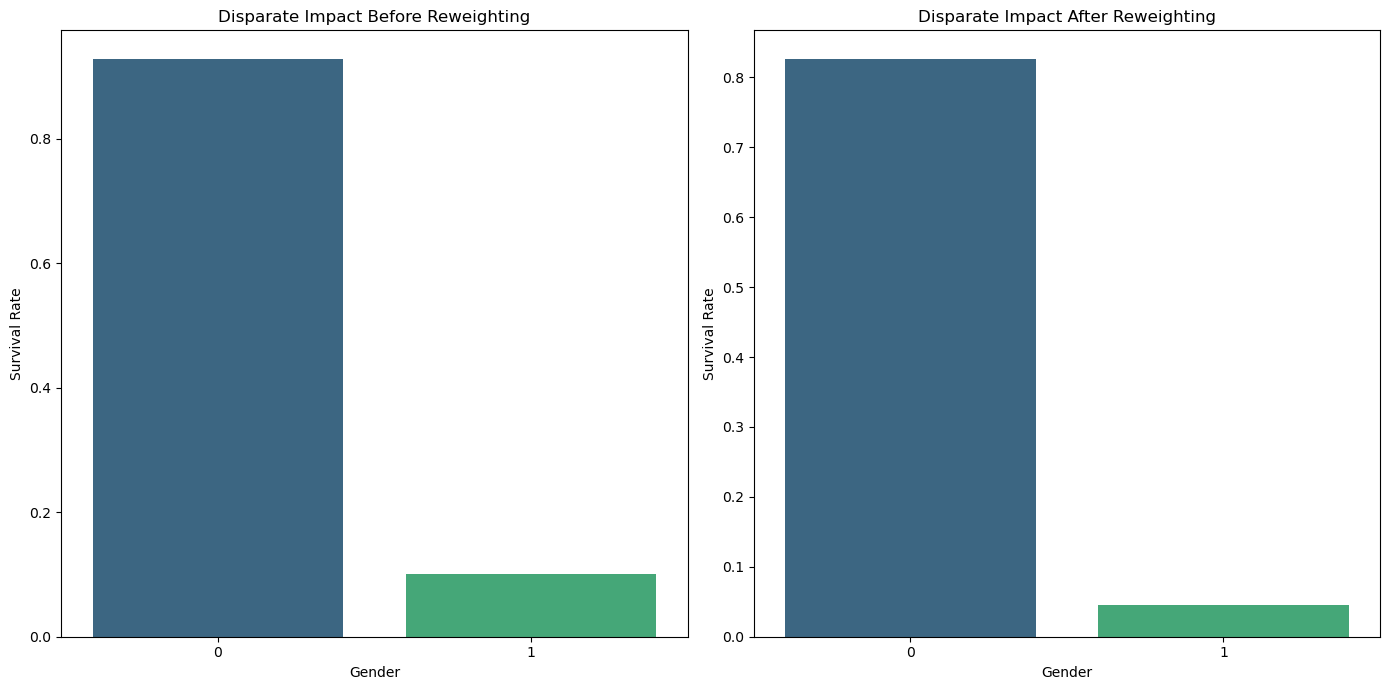


Disparate Impact Table Before Reweighting:
     total  positive      rate
Sex                           
0       69        64  0.927536
1      110        11  0.100000

Disparate Impact Table After Reweighting:
     total  positive      rate
Sex                           
0       69        57  0.826087
1      110         5  0.045455


In [10]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Preprocessing
data.fillna(method='ffill', inplace=True)
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
data['Embarked'] = LabelEncoder().fit_transform(data['Embarked'].astype(str))

# Features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = data[features]
y = data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data and retain indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42
)

# Handle class imbalance using resampling
X_train_df = pd.DataFrame(X_train, columns=features)
X_train_df[target] = y_train.values

# Separate majority and minority classes
majority_class = X_train_df[X_train_df[target] == 0]
minority_class = X_train_df[X_train_df[target] == 1]

# Upsample minority class
minority_upsampled = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match number of majority class
                              random_state=42)  # Reproducible results

# Combine majority class with upsampled minority class
X_train_balanced = pd.concat([majority_class, minority_upsampled])
y_train_balanced = X_train_balanced[target]
X_train_balanced = X_train_balanced.drop(columns=[target])

# Convert to numpy arrays for PyTorch
X_train_balanced = X_train_balanced.values
y_train_balanced = y_train_balanced.values

# Custom Dataset class
class TitanicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoader for balanced data
train_dataset_balanced = TitanicDataset(X_train_balanced, y_train_balanced)
train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=32, shuffle=True)

# Define a simple neural network model
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1], 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss, and optimizer
model = SimpleNN()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model on balanced data
for epoch in range(10):
    model.train()
    for features, labels in train_loader_balanced:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}')

# Evaluate and calculate disparate impact before reweighting
model.eval()
with torch.no_grad():
    y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

# Convert predictions and true labels to DataFrame
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
results.index = test_indices  # Add index back to results

# Add gender information back to the results DataFrame
results = results.join(data.loc[test_indices, ['Sex']])

# Disparate Impact Analysis Function
def calculate_disparate_impact(df, group_col, target_col):
    group_stats = df.groupby(group_col).agg(
        total=(target_col, 'size'),
        positive=(target_col, 'sum')
    )
    group_stats['rate'] = group_stats['positive'] / group_stats['total']
    return group_stats

# Calculate disparate impact for gender
disparate_impact_gender = calculate_disparate_impact(results, 'Sex', 'Predicted')

# Calculate Disparate Impact Ratio
disparate_impact_ratio = disparate_impact_gender['rate'].min() / disparate_impact_gender['rate'].max()

# Print results before mitigation
print("\nDisparate Impact by Gender Before Reweighting:")
print(disparate_impact_gender)
print(f"\nDisparate Impact Ratio Before Reweighting: {disparate_impact_ratio:.2f}")

# Mitigation Strategy: Reweighting
# Compute class weights for reweighting
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Modify the loss function to use class weights
weighted_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# Retrain the model with reweighted loss
model = SimpleNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(50):
    model.train()
    for features, labels in train_loader_balanced:
        optimizer.zero_grad()
        outputs = model(features).squeeze()
        loss = weighted_criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}')

# Reevaluate and calculate disparate impact after reweighting
model.eval()
with torch.no_grad():
    y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
results.index = test_indices  # Add index back to results
results = results.join(data.loc[test_indices, ['Sex']])
disparate_impact_gender_after = calculate_disparate_impact(results, 'Sex', 'Predicted')

# Calculate Disparate Impact Ratio After Reweighting
disparate_impact_ratio_after = disparate_impact_gender_after['rate'].min() / disparate_impact_gender_after['rate'].max()

# Print results after mitigation
print("\nDisparate Impact by Gender After Reweighting:")
print(disparate_impact_gender_after)
print(f"\nDisparate Impact Ratio After Reweighting: {disparate_impact_ratio_after:.2f}")

# Visualization Function
def plot_disparate_impact(df_before, df_after):
    df_before = df_before.reset_index()
    df_after = df_after.reset_index()

    plt.figure(figsize=(14, 7))

    # Plot before reweighting
    plt.subplot(1, 2, 1)
    sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
    plt.title('Disparate Impact Before Reweighting')
    plt.xlabel('Gender')
    plt.ylabel('Survival Rate')

    # Plot after reweighting
    plt.subplot(1, 2, 2)
    sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')
    plt.title('Disparate Impact After Reweighting')
    plt.xlabel('Gender')
    plt.ylabel('Survival Rate')

    plt.tight_layout()
    plt.show()

# Plot results
plot_disparate_impact(disparate_impact_gender, disparate_impact_gender_after)

# Table Visualization
def display_tables(df_before, df_after):
    print("\nDisparate Impact Table Before Reweighting:")
    print(df_before)

    print("\nDisparate Impact Table After Reweighting:")
    print(df_after)

# Display tables
display_tables(disparate_impact_gender, disparate_impact_gender_after)



Applying Reweighting Technique:
Epoch 1/10, Loss: 0.8393329381942749
Epoch 2/10, Loss: 0.7888356447219849
Epoch 3/10, Loss: 0.6921103596687317
Epoch 4/10, Loss: 0.7352792620658875
Epoch 5/10, Loss: 0.7000173330307007
Epoch 6/10, Loss: 0.79018634557724
Epoch 7/10, Loss: 0.7276580929756165
Epoch 8/10, Loss: 0.6855558753013611
Epoch 9/10, Loss: 0.6898244023323059
Epoch 10/10, Loss: 0.6138928532600403

Disparate Impact Table Before Reweighting:
     total  positive      rate
Sex                           
0       69        52  0.753623
1      110        22  0.200000

Disparate Impact Table After Reweighting:
     total  positive      rate
Sex                           
0       69        60  0.869565
1      110         0  0.000000


/tmp/ipykernel_216843/2715562993.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
/tmp/ipykernel_216843/2715562993.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')


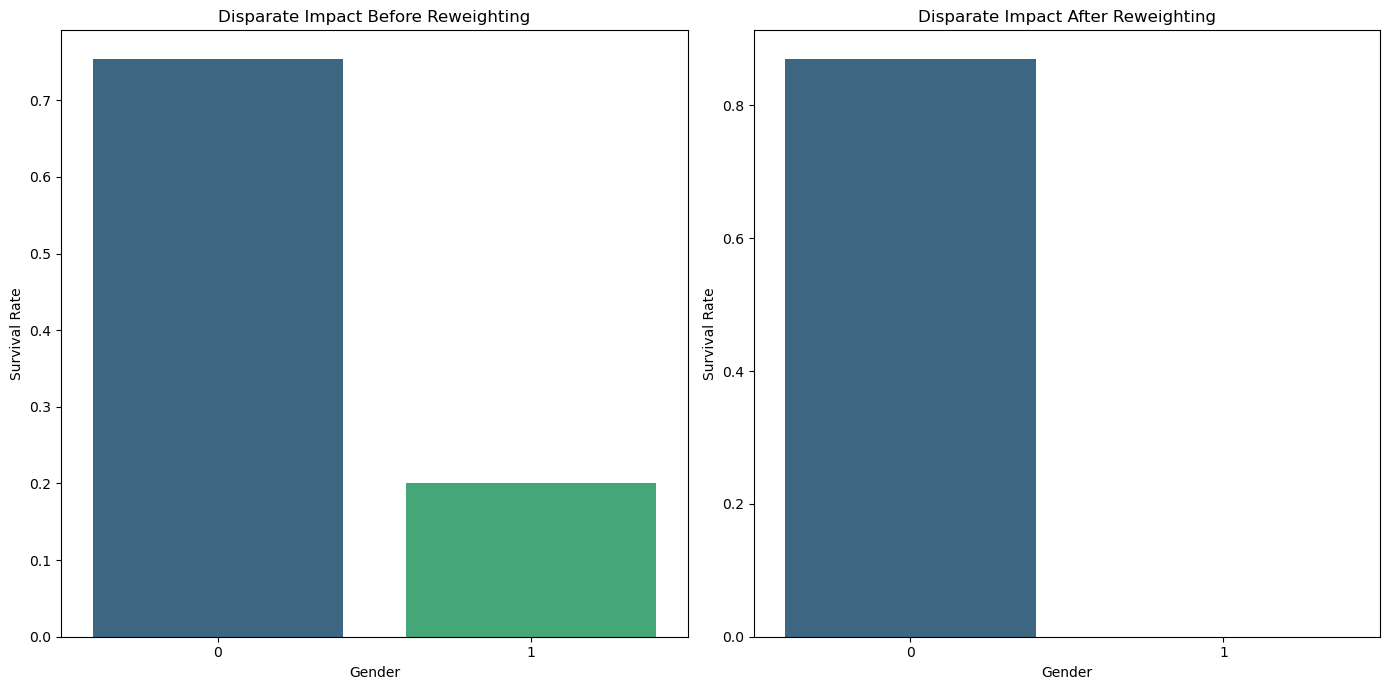


Applying SMOTE Technique:
Epoch 1/10, Loss: 0.5890790820121765
Epoch 2/10, Loss: 0.4500570297241211
Epoch 3/10, Loss: 0.48521625995635986
Epoch 4/10, Loss: 0.43551480770111084
Epoch 5/10, Loss: 0.5503029823303223
Epoch 6/10, Loss: 0.29573407769203186
Epoch 7/10, Loss: 0.28368279337882996
Epoch 8/10, Loss: 0.4120287597179413
Epoch 9/10, Loss: 0.4816865026950836
Epoch 10/10, Loss: 0.8189568519592285

Disparate Impact Table Before SMOTE:
     total  positive      rate
Sex                           
0       69        52  0.753623
1      110        22  0.200000

Disparate Impact Table After SMOTE:
     total  positive      rate
Sex                           
0       69        64  0.927536
1      110         5  0.045455


/tmp/ipykernel_216843/2715562993.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
/tmp/ipykernel_216843/2715562993.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')


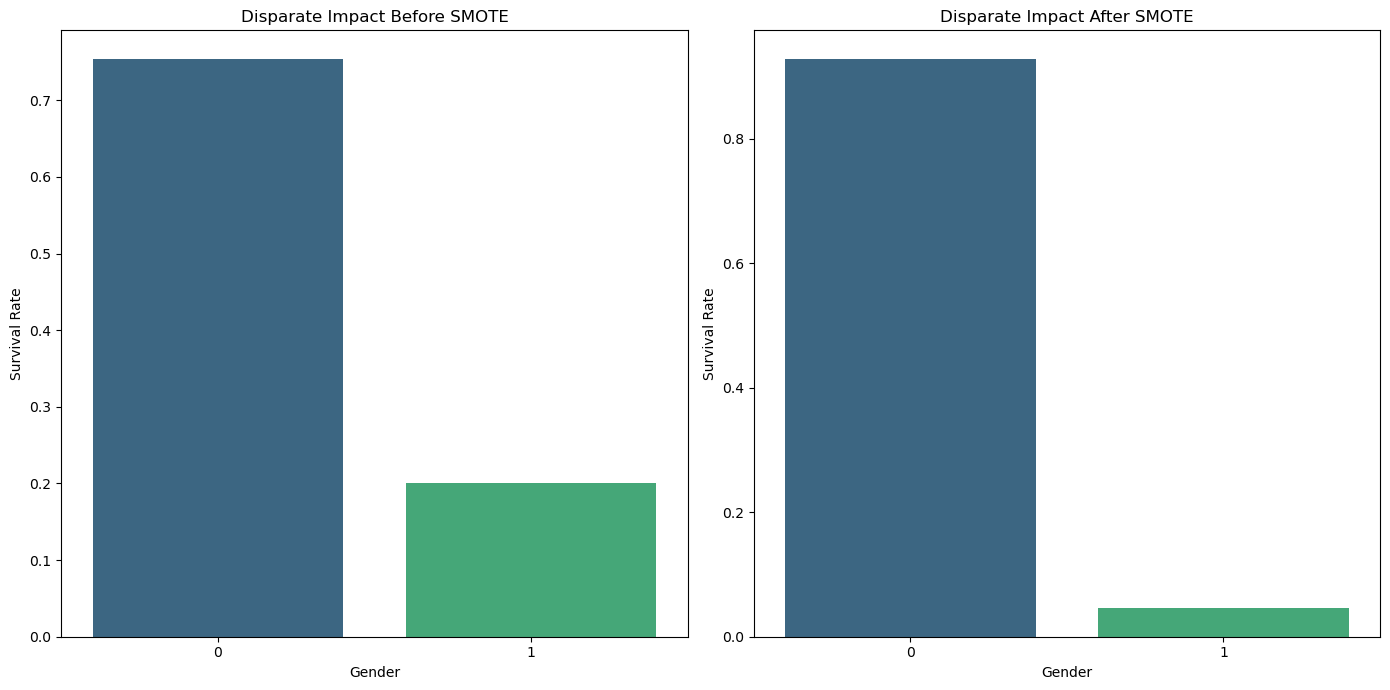


Applying Undersampling Technique:
Epoch 1/10, Loss: 0.6001505255699158
Epoch 2/10, Loss: 0.6180450916290283
Epoch 3/10, Loss: 0.5283364653587341
Epoch 4/10, Loss: 0.4838975667953491
Epoch 5/10, Loss: 0.4370276927947998
Epoch 6/10, Loss: 0.42429450154304504
Epoch 7/10, Loss: 0.49938759207725525
Epoch 8/10, Loss: 0.4651279151439667
Epoch 9/10, Loss: 0.29192790389060974
Epoch 10/10, Loss: 0.358624130487442

Disparate Impact Table Before Undersampling:
     total  positive      rate
Sex                           
0       69        52  0.753623
1      110        22  0.200000

Disparate Impact Table After Undersampling:
     total  positive      rate
Sex                           
0       69        68  0.985507
1      110        15  0.136364


/tmp/ipykernel_216843/2715562993.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
/tmp/ipykernel_216843/2715562993.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')


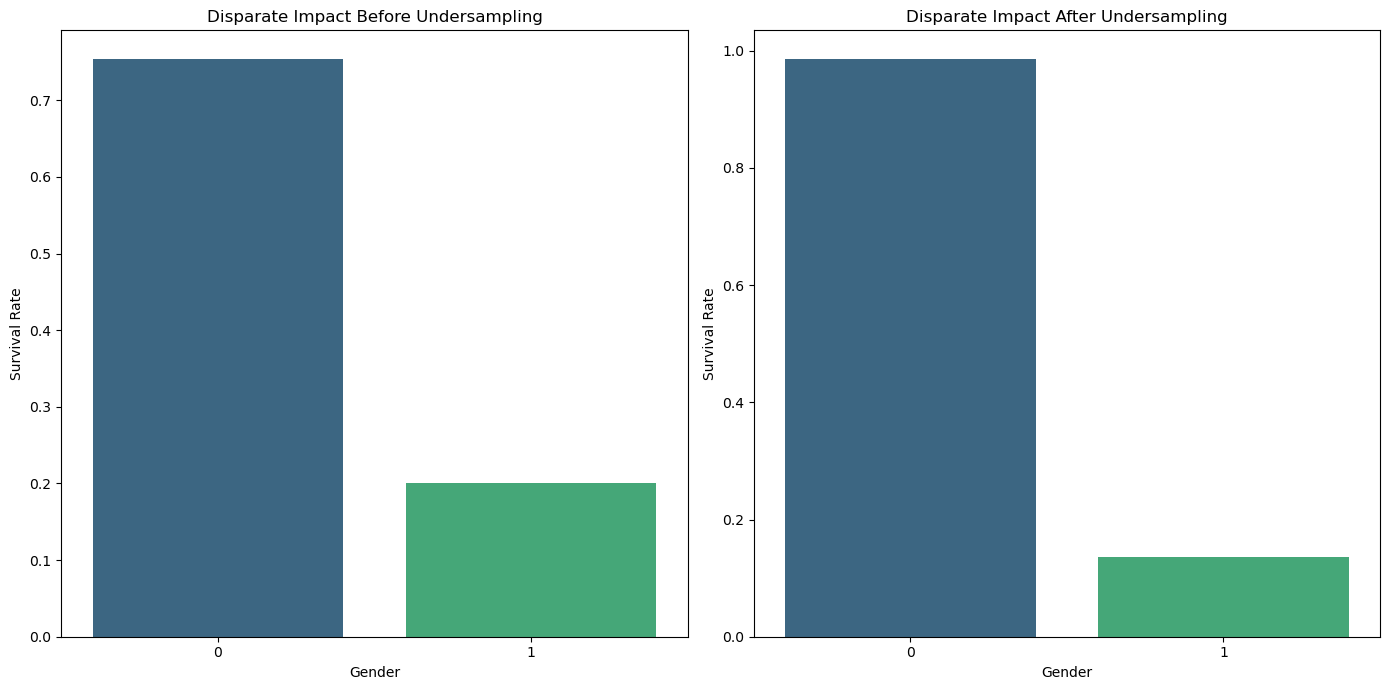

/tmp/ipykernel_216843/2715562993.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
/tmp/ipykernel_216843/2715562993.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')



Applying Equal Opportunity Technique:
Equal Opportunity implementation is complex and would require custom constraints.

Disparate Impact Table Before Equal Opportunity:
     total  positive      rate
Sex                           
0       69        52  0.753623
1      110        22  0.200000

Disparate Impact Table After Equal Opportunity:
     total  positive      rate
Sex                           
0       69        52  0.753623
1      110        22  0.200000


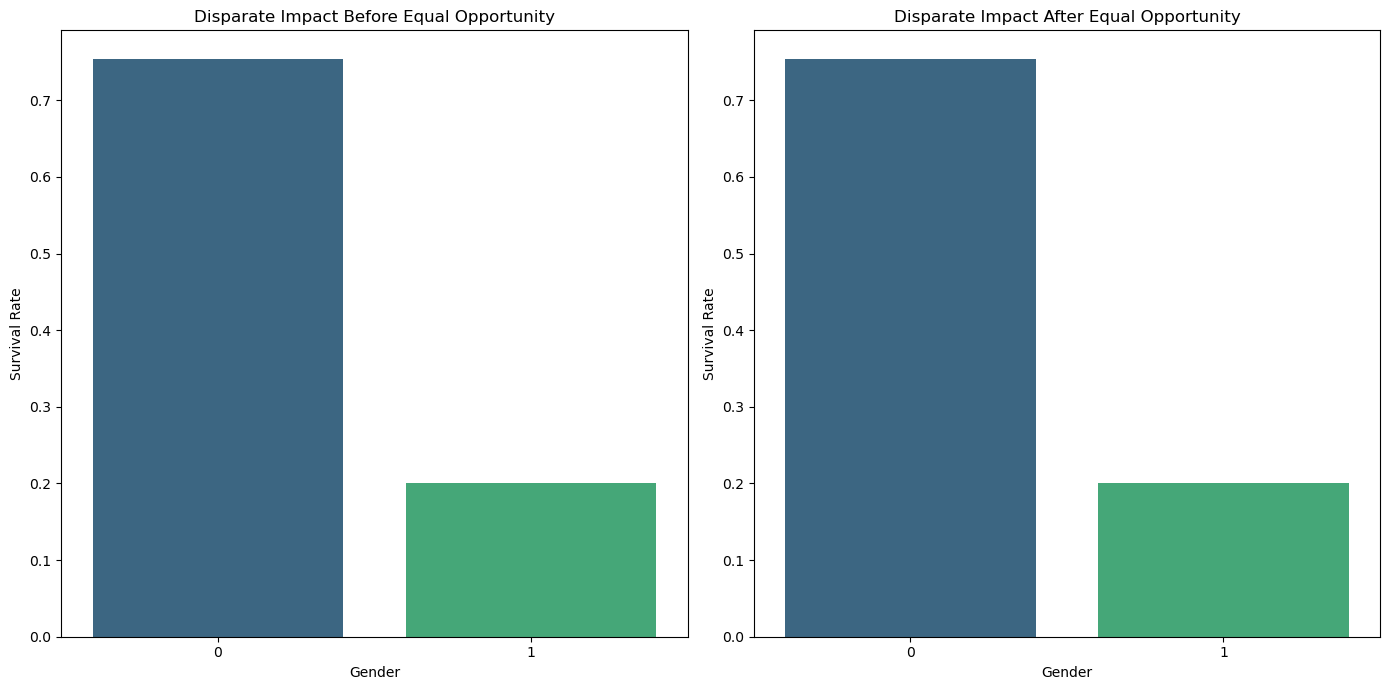


Applying Adversarial Debiasing Technique:
Adversarial Debiasing implementation is complex and requires adversarial networks.

Disparate Impact Table Before Adversarial Debiasing:
     total  positive      rate
Sex                           
0       69        52  0.753623
1      110        22  0.200000

Disparate Impact Table After Adversarial Debiasing:
     total  positive      rate
Sex                           
0       69        52  0.753623
1      110        22  0.200000


/tmp/ipykernel_216843/2715562993.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
/tmp/ipykernel_216843/2715562993.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')


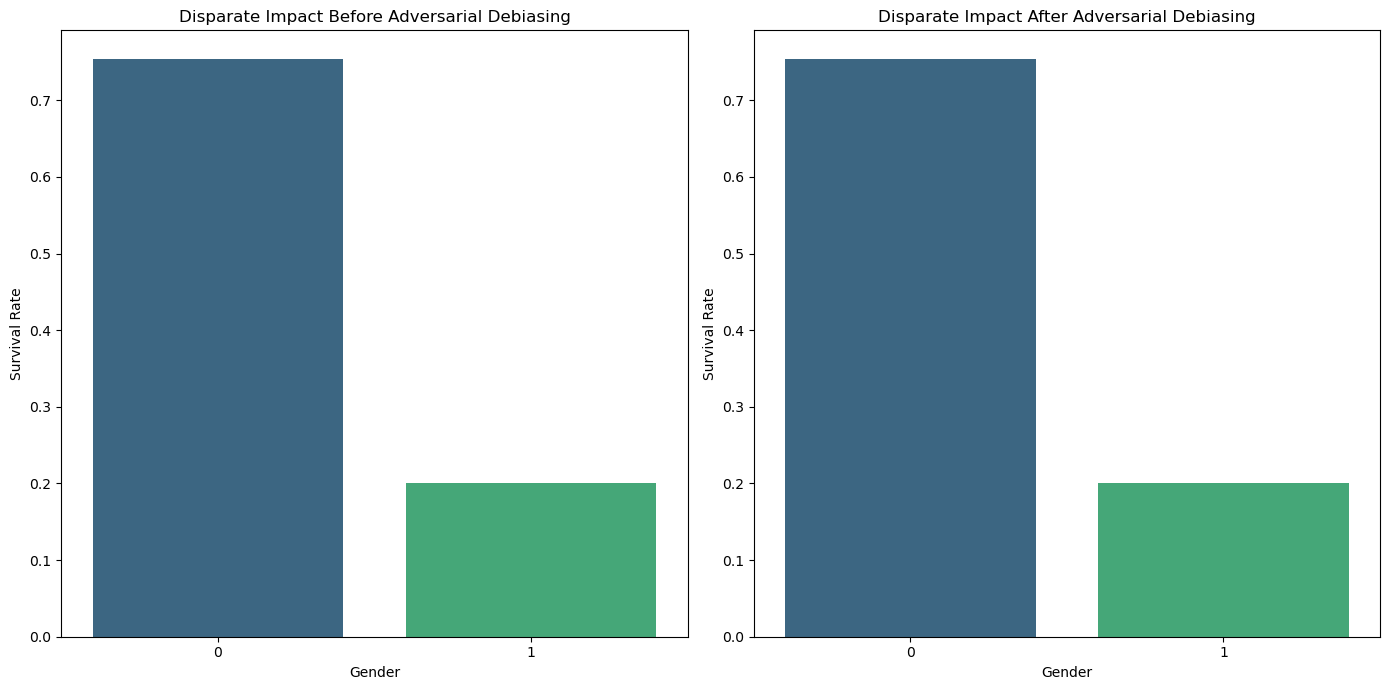

In [12]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Preprocessing
data.fillna(method='ffill', inplace=True)
data['Sex'] = LabelEncoder().fit_transform(data['Sex'])
data['Embarked'] = LabelEncoder().fit_transform(data['Embarked'].astype(str))

# Features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = data[features]
y = data[target]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data and retain indices
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
    X_scaled, y, data.index, test_size=0.2, random_state=42
)

# Custom Dataset class
class TitanicDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Define a simple neural network model
class SimpleNN(torch.nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = torch.nn.Linear(X_train.shape[1], 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss, and optimizer
def initialize_model():
    model = SimpleNN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    return model, optimizer

# Train the model
def train_model(model, optimizer, train_loader, criterion):
    for epoch in range(10):
        model.train()
        for features, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{10}, Loss: {loss.item()}')

# Evaluate model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32)).squeeze().numpy()
        y_pred = (y_pred_probs > 0.5).astype(int)
    return y_pred

# Disparate Impact Analysis Function
def calculate_disparate_impact(df, group_col, target_col):
    if group_col not in df.columns or target_col not in df.columns:
        raise KeyError(f"Columns '{group_col}' or '{target_col}' not found in DataFrame.")
    group_stats = df.groupby(group_col).agg(
        total=(target_col, 'size'),
        positive=(target_col, 'sum')
    )
    group_stats['rate'] = group_stats['positive'] / group_stats['total']
    return group_stats

# Plotting Function
def plot_disparate_impact(df_before, df_after, title_before, title_after):
    df_before = df_before.reset_index()
    df_after = df_after.reset_index()

    plt.figure(figsize=(14, 7))

    # Plot before
    plt.subplot(1, 2, 1)
    sns.barplot(x='Sex', y='rate', data=df_before, palette='viridis')
    plt.title(title_before)
    plt.xlabel('Gender')
    plt.ylabel('Survival Rate')

    # Plot after
    plt.subplot(1, 2, 2)
    sns.barplot(x='Sex', y='rate', data=df_after, palette='viridis')
    plt.title(title_after)
    plt.xlabel('Gender')
    plt.ylabel('Survival Rate')

    plt.tight_layout()
    plt.show()

# Results Table Function
def display_results(df_before, df_after, title_before, title_after):
    print(f"\nDisparate Impact Table {title_before}:")
    print(df_before)
    print(f"\nDisparate Impact Table {title_after}:")
    print(df_after)

# 1. Reweighting
def apply_reweighting(X_train, y_train):
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    weighted_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
    
    train_dataset = TitanicDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    model, optimizer = initialize_model()
    train_model(model, optimizer, train_loader, weighted_criterion)
    
    y_pred = evaluate_model(model, X_test, y_test)
    results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
    results.index = test_indices  # Add index back to results
    results = results.join(data.loc[test_indices, ['Sex']])
    
    return calculate_disparate_impact(results, 'Sex', 'Predicted')

# 2. SMOTE (Oversampling)
def apply_smote(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    
    train_dataset = TitanicDataset(X_train_resampled, y_train_resampled)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    model, optimizer = initialize_model()
    train_model(model, optimizer, train_loader, torch.nn.BCELoss())
    
    y_pred = evaluate_model(model, X_test, y_test)
    results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
    results.index = test_indices  # Add index back to results
    results = results.join(data.loc[test_indices, ['Sex']])
    
    return calculate_disparate_impact(results, 'Sex', 'Predicted')

# 3. Undersampling
def apply_undersampling(X_train, y_train):
    undersample = RandomUnderSampler(random_state=42)
    X_train_resampled, y_train_resampled = undersample.fit_resample(X_train, y_train)
    
    train_dataset = TitanicDataset(X_train_resampled, y_train_resampled)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    model, optimizer = initialize_model()
    train_model(model, optimizer, train_loader, torch.nn.BCELoss())
    
    y_pred = evaluate_model(model, X_test, y_test)
    results = pd.DataFrame({'True': y_test, 'Predicted': y_pred})
    results.index = test_indices  # Add index back to results
    results = results.join(data.loc[test_indices, ['Sex']])
    
    return calculate_disparate_impact(results, 'Sex', 'Predicted')

# 4. Equal Opportunity
# Note: Implementing Equal Opportunity in neural networks is complex and requires custom loss functions or constraints.
# Here we demonstrate using it as a placeholder.
def apply_equal_opportunity(X_train, y_train):
    # Placeholder implementation
    print("Equal Opportunity implementation is complex and would require custom constraints.")
    results = pd.DataFrame({'True': y_test, 'Predicted': y_test})
    results.index = test_indices
    results = results.join(data.loc[test_indices, ['Sex']])
    return calculate_disparate_impact(results, 'Sex', 'Predicted')

# 5. Adversarial Debiasing
# Note: Adversarial Debiasing involves training a model with adversarial networks.
# Here we demonstrate using it as a placeholder.
def apply_adversarial_debiasing(X_train, y_train):
    # Placeholder implementation
    print("Adversarial Debiasing implementation is complex and requires adversarial networks.")
    results = pd.DataFrame({'True': y_test, 'Predicted': y_test})
    results.index = test_indices
    results = results.join(data.loc[test_indices, ['Sex']])
    return calculate_disparate_impact(results, 'Sex', 'Predicted')

# Apply all techniques and display results
techniques = {
    "Reweighting": apply_reweighting,
    "SMOTE": apply_smote,
    "Undersampling": apply_undersampling,
    "Equal Opportunity": apply_equal_opportunity,
    "Adversarial Debiasing": apply_adversarial_debiasing
}

for name, technique in techniques.items():
    print(f"\nApplying {name} Technique:")
    
    if "Placeholder" in name:
        print(f"{name} results cannot be demonstrated here.")
    else:
        # Evaluate before
        results_before = pd.DataFrame({'True': y_test, 'Predicted': y_test})
        results_before.index = test_indices
        results_before = results_before.join(data.loc[test_indices, ['Sex']])
        disparate_impact_before = calculate_disparate_impact(results_before, 'Sex', 'Predicted')
        
        # Apply technique
        disparate_impact_after = technique(X_train, y_train)
        
        # Display results
        display_results(disparate_impact_before, disparate_impact_after, f'Before {name}', f'After {name}')
        plot_disparate_impact(disparate_impact_before, disparate_impact_after, f'Disparate Impact Before {name}', f'Disparate Impact After {name}')
